In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/논문/Youtube-Recommendation/Movie-Lens

/content/drive/MyDrive/논문/Youtube-Recommendation/Movie-Lens


In [ ]:
ls

 dataset_item_pca.pkl
 dataset.pkl
 logs/
 meta.tsv
 ml-100k/
 model.png
 MovieLens_Youtube_Recommendation_Candidate_Generation_Network.ipynb
 movielens.zip
 Untitled0.ipynb
 vecs.tsv
'Wine_Candidate_Rec_[Youtube_Recommendation_Candidate_Generation_Network].ipynb'


In [ ]:
import os
import sys
import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm

In [ ]:
data = joblib.load('./dataset_item_pca.pkl')
locals().update(data)

In [ ]:
train

,userID,wine_id,rating,enc_userID,enc_wine_id,recent,like,dislike,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49,pca_50
0,19484511,2532733,4.0,0,0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[13, 20, 23, 25, 35, 38, 40, 41, 45, 46]","[6, 15, 28, 30, 31, 37, 61, 62, 67, 70]",-9.726277e+04,16040.469094,-11834.849535,-6547.330643,2735.025628,13320.959949,430.512319,-3067.678767,2358.609361,-59.474013,1131.330806,-980.411927,-1579.100669,-332.264259,-392.833403,-119.201227,-950.435431,-54.988317,-164.926150,-203.276961,16.626171,-14.214548,4.118338,-52.338718,10.227645,31.290808,10.105181,-4.036549,-20.940962,-0.032359,0.363253,7.574852,6.171615,-7.904048,-2.053102,8.796952,0.464210,-13.096916,-2.233700,7.378637,1.417213,-6.687278,5.637857,6.829027,2.178105,-2.342787,-13.324872,2.432840,7.759076,5.353219
1,19484511,1253802,3.5,0,1,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]","[13, 20, 23, 25, 35, 38, 40, 41, 45, 46]","[6, 15, 28, 30, 31, 37, 61, 62, 67, 70]",-1.304583e+05,7702.387568,-10132.155805,-5470.020665,-627.424004,6442.912900,-4933.776131,2414.187988,-3974.049719,271.974245,2098.027236,-2549.673163,-883.745700,-44.411283,355.783538,-35.621377,1439.014623,-22.382805,-139.932431,-181.416281,12.937172,-16.822075,4.602952,-24.893519,-2.147394,25.135257,-2.415354,-4.189015,5.088653,0.825852,0.094412,-6.354602,-4.870937,-8.391250,2.566599,5.450670,3.489076,7.477219,-2.683876,-0.605119,2.799734,-5.239312,3.961697,12.408006,6.073100,-7.546990,-12.546061,0.246672,3.099425,7.057004
2,19484511,1123441,3.5,0,2,"[3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[13, 20, 23, 25, 35, 38, 40, 41, 45, 46]","[6, 15, 28, 30, 31, 37, 61, 62, 67, 70]",-1.743521e+05,-10104.676062,3397.812846,-392.398246,189.597868,-1044.672157,64.615015,-522.148589,-234.011328,-680.722201,205.062269,258.710680,263.643574,-9.441355,-143.667867,-39.837945,95.228507,-3.983404,-10.541505,-4.115442,-5.497397,-1.643427,3.739896,-1.641185,4.004606,-0.657016,0.872661,7.096236,-1.404333,0.189134,-1.581217,0.877003,-0.665087,-3.458213,-2.407344,-2.017662,-0.380771,-0.417670,1.199667,-1.295254,1.439871,-0.327708,2.474568,0.737225,0.220733,0.995639,0.786773,-0.625199,-0.121658,-0.512128
3,19484511,1157656,3.5,0,3,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13]","[13, 20, 23, 25, 35, 38, 40, 41, 45, 46]","[6, 15, 28, 30, 31, 37, 61, 62, 67, 70]",1.508002e+06,32910.216387,45556.683819,60063.941757,45410.941724,133.886998,-1261.691794,-14250.022340,-33654.115243,-15402.134171,237.787496,-1394.019194,-441.619897,3701.367151,1845.722094,4094.794652,-1118.061152,24.051491,-35.690231,50.840670,-97.955372,25.850071,70.847523,-48.037555,-110.675260,-58.738818,67.510492,79.393094,19.078115,-10.028375,-6.755624,45.664766,25.963299,-9.198557,-2.699026,-5.399754,-29.122130,-12.248266,-23.491003,15.405502,-17.481976,6.886260,-20.550430,-7.445323,-5.017713,-76.434898,-15.113642,27.401769,-26.849115,-10.134520
4,19484511,1134756,3.5,0,4,"[5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[13, 20, 23, 25, 35, 38, 40, 41, 45, 46]","[6, 15, 28, 30, 31, 37, 61, 62, 67, 70]",8.247904e+04,62330.292660,25855.282503,47259.918268,-1906.614962,-2883.400074,-1429.989602,-7930.571868,-10554.542969,-8395.151594,-983.341037,-1314.107035,1033.873981,1378.198949,-1454.975059,2067.573555,-540.814491,-606.141199,-52.787211,69.659390,38.793525,30.864047,-1.953564,-3.399451,-32.133878,0.949801,-15.683287,-15.570368,6.168340,-1.863670,-12.570518,20.270075,1.024007,-6.867264,11.716491,-20.420278,21.037545,10.794934,6.631216,10.553812,-10.205645,0.382986,-11.753803,-2.322315,-0.951191,-19.102697,-0.436638,-5.353860,-3.307175,-2.662975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
minmax = scaler.fit_transform(train.loc[train['userID'] == 19484511, 'rating'].values.reshape(-1, 1))

In [ ]:
train['label'] = None
for u in tqdm(train.userID.unique()):
  minmax = scaler.fit_transform(train.loc[train['userID'] == u, 'rating'].values.reshape(-1, 1))
  avg = np.mean(minmax)

  res = (minmax > np.mean(minmax)).astype(int)
  res = [r[0] for r in res]

  train.loc[train['userID'] == u, 'label'] = res

100%|██████████| 6343/6343 [01:54<00:00, 55.34it/s]


In [ ]:
train.label.value_counts()

1    499407
0    438349
Name: label, dtype: int64

In [ ]:
train = train.sample(frac = 1)

In [ ]:
EMBEDDING_DIMS = 100
DENSE_UNITS = 64
DROPOUT_PCT = 0.0
ALPHA = 0.0
NUM_CLASSES = 50862
LEARNING_RATE = 0.003

In [ ]:
import tensorflow as tf
import keras
class MaskedEmbeddingsAggregatorLayer(tf.keras.layers.Layer):
    def __init__(self, agg_mode='sum', **kwargs):
        super(MaskedEmbeddingsAggregatorLayer, self).__init__(**kwargs)

        if agg_mode not in ['sum', 'mean']:
            raise NotImplementedError('mode {} not implemented!'.format(agg_mode))
        self.agg_mode = agg_mode
    
    @tf.function
    def call(self, inputs, mask=None):
        masked_embeddings = tf.ragged.boolean_mask(inputs, mask)
        if self.agg_mode == 'sum':
            aggregated =  tf.reduce_sum(masked_embeddings, axis=1)
        elif self.agg_mode == 'mean':
            aggregated = tf.reduce_mean(masked_embeddings, axis=1)
        
        return aggregated
    
    def get_config(self):
        # this is used when loading a saved model that uses a custom layer
        return {'agg_mode': self.agg_mode}

In [ ]:
class L2NormLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(L2NormLayer, self).__init__(**kwargs)
    
    @tf.function
    def call(self, inputs, mask=None):
        if mask is not None:
            inputs = tf.ragged.boolean_mask(inputs, mask).to_tensor()
        return tf.math.l2_normalize(inputs, axis=-1)

    def compute_mask(self, inputs, mask):
        return mask
    

In [ ]:
#---inputs
import tensorflow as tf
import datetime
import os
input_profile = tf.keras.Input(shape=(50, ), name='profile')
input_recent = tf.keras.Input(shape=(None, ), name='recent')
# inp_liked = tf.keras.layers.Input(shape=(None,), name='like')
# inp_disliked = tf.keras.layers.Input(shape=(None,), name='dislike')\
inp_relation = tf.keras.layers.Input(shape = (None, ), name = 'relation')


# --- layers
# features_embedding_layer = tf.keras.layers.Embedding(input_dim=NUM_CLASSES, output_dim=EMBEDDING_DIMS, 
#                                             mask_zero=True, trainable=True, name='features_embeddings')
labels_embedding_layer = tf.keras.layers.Embedding(input_dim = NUM_CLASSES, output_dim = EMBEDDING_DIMS, 
                                            mask_zero=True, trainable=True, name='labels_embeddings')

avg_embeddings = MaskedEmbeddingsAggregatorLayer(agg_mode='mean', name='aggregate_embeddings')

dense_1 = tf.keras.layers.Dense(units=256, name='dense_1')
dense_2 = tf.keras.layers.Dense(units=128, name='dense_2')
dense_3 = tf.keras.layers.Dense(units=64, name='dense_3')
l2_norm_1 = L2NormLayer(name='l2_norm_1')

dense_output = tf.keras.layers.Dense(1,
                                     activation=tf.nn.softmax,
                                     name='dense_output')

# --- features

# features_embeddings = features_embedding_layer(input_profile)
# l2_norm_features = l2_norm_1(features_embeddings)
# avg_features = avg_embeddings(l2_norm_features)

dense_profile = tf.keras.layers.Dense(units = 32, name='dense_profile')
dense_1_profile = dense_profile(input_profile)
dense_1_profile_relu = tf.keras.layers.ReLU(name='dense_1_profile_relu')(dense_1_profile)

labels_relation_embeddings = labels_embedding_layer(inp_relation)
l2_norm_relation = l2_norm_1(labels_relation_embeddings)
avg_relation = avg_embeddings(l2_norm_relation)

# labels_liked_embeddings = labels_embedding_layer(inp_liked)
# l2_norm_liked = l2_norm_1(labels_liked_embeddings)
# avg_liked = avg_embeddings(l2_norm_liked)

# labels_disliked_embeddings = labels_embedding_layer(inp_disliked)
# l2_norm_disliked = l2_norm_1(labels_disliked_embeddings)
# avg_disliked = avg_embeddings(l2_norm_disliked)

labels_genre_embeddings = labels_embedding_layer(input_recent)
l2_norm_genre = l2_norm_1(labels_genre_embeddings)
avg_recent = avg_embeddings(l2_norm_genre)



concat_inputs = tf.keras.layers.Concatenate(axis=1)([
                                                    #  avg_features,
                                                     dense_1_profile_relu,
                                                    #  avg_liked,
                                                     avg_relation,
                                                    #  avg_disliked,
                                                     avg_recent
                                                     ])
# Dense Layers
dense_1_features = dense_1(concat_inputs)
dense_1_relu = tf.keras.layers.ReLU(name='dense_1_relu')(dense_1_features)
dense_1_batch_norm = tf.keras.layers.BatchNormalization(name='dense_1_batch_norm')(dense_1_relu)

dense_2_features = dense_2(dense_1_relu)
dense_2_relu = tf.keras.layers.ReLU(name='dense_2_relu')(dense_2_features)
dense_2_batch_norm = tf.keras.layers.BatchNormalization(name='dense_2_batch_norm')(dense_2_relu)

dense_3_features = dense_3(dense_2_relu)
dense_3_relu = tf.keras.layers.ReLU(name='dense_3_relu')(dense_3_features)
dense_3_batch_norm = tf.keras.layers.BatchNormalization(name='dense_3_batch_norm')(dense_3_relu)
outputs = dense_output(dense_3_batch_norm)

#Optimizer
optimiser = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)

#--- prep model
model = tf.keras.models.Model(
    inputs=[
            input_profile,
            # inp_liked,
            inp_relation
            # inp_disliked
            ,input_recent
            ],
    outputs=[outputs]
)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
model.compile(optimizer = optimiser,
              loss = tf.keras.losses.BinaryCrossentropy(),
              # loss='mean_squared_error',
              metrics=['acc'])


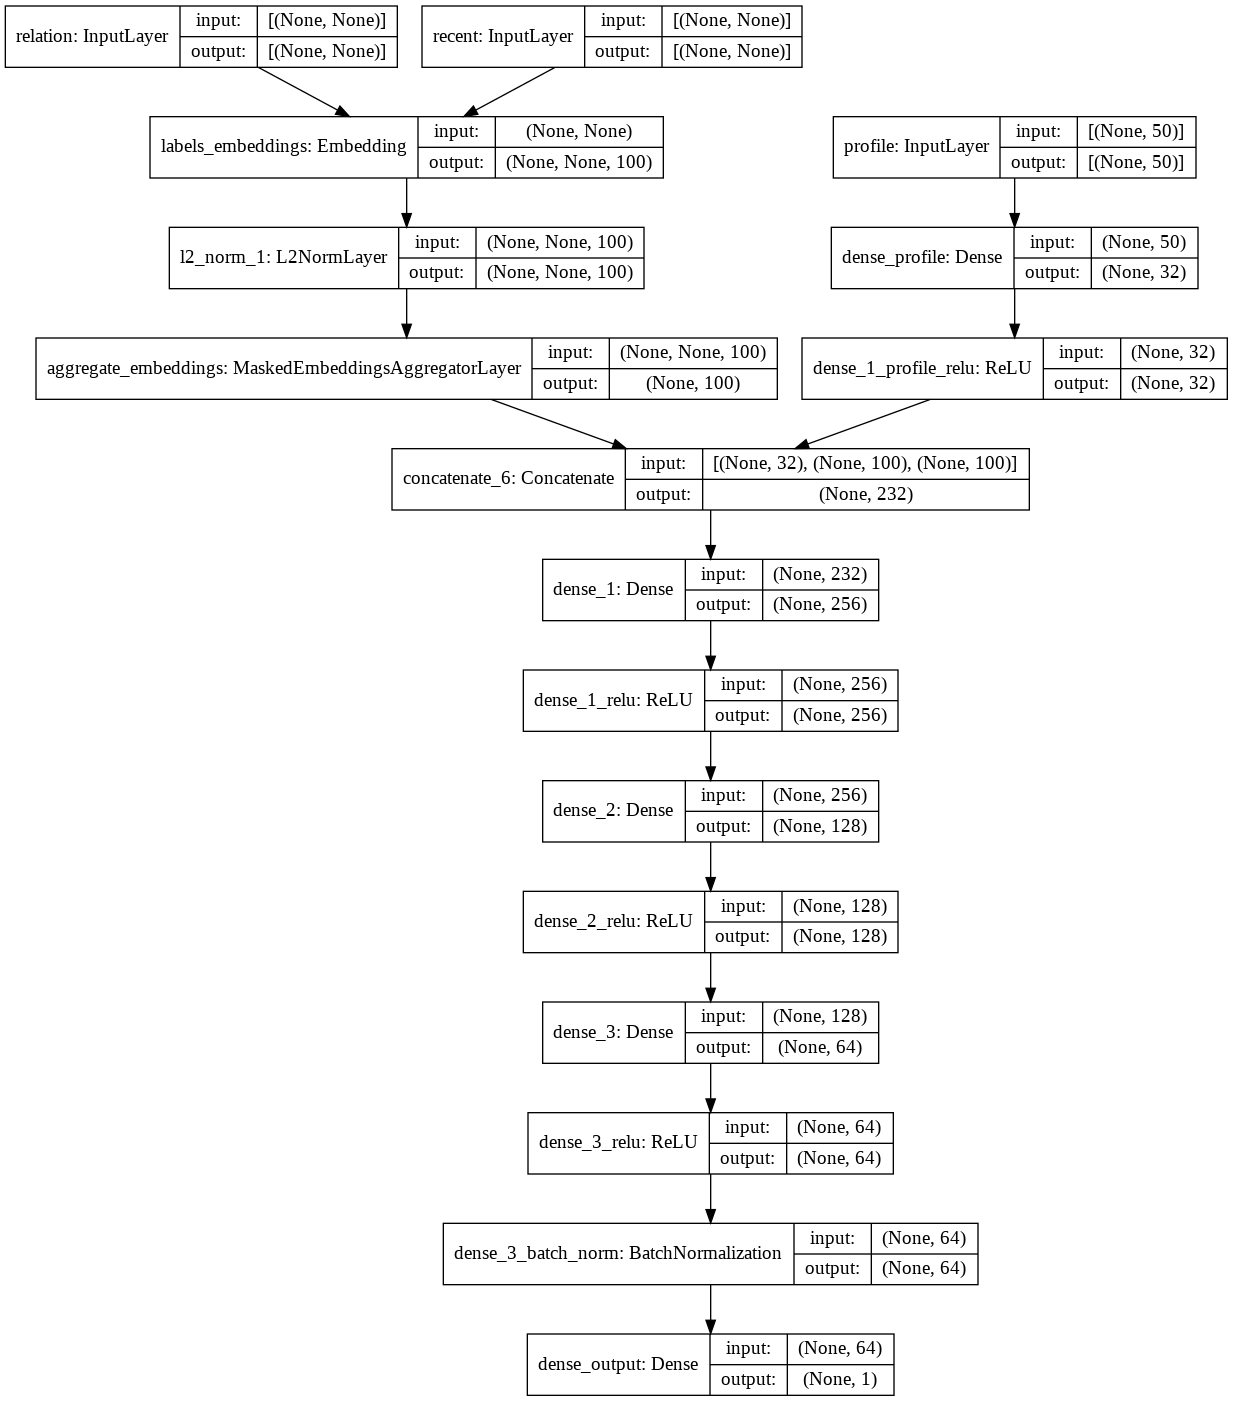

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True,dpi=96)

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
relation (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
recent (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
profile (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
labels_embeddings (Embedding)   (None, None, 100)    5086200     relation[0][0]                   
                                                                 recent[0][0]               

In [ ]:
callbacks_list = [
                  keras.callbacks.EarlyStopping(
                    monitor = 'acc',
                    patience = 10
                  )
]

In [ ]:
train.iloc[:, 8:-1].shape

(937756, 50)

In [ ]:
model.fit([
           train.iloc[:, 8:-1].fillna(0).values,
          #  tf.keras.preprocessing.sequence.pad_sequences(train['like']),
           train[['enc_userID', 'enc_wine_id']].values,
          #  tf.keras.preprocessing.sequence.pad_sequences(train['dislike']),
           tf.keras.preprocessing.sequence.pad_sequences(train['recent'])
           ],
          train['label'].astype(int).values,
          # callbacks=[tensorboard_callback],
          batch_size = 512,
          # steps_per_epoch = 1,
          epochs = 1000,
          # callbacks = callbacks_list,
          # validation_data = ([
          #                     tf.keras.preprocessing.sequence.pad_sequences(test['like']),
          #                     tf.keras.preprocessing.sequence.pad_sequences(test['dislike']),
          #                     tf.keras.preprocessing.sequence.pad_sequences(test['recent'])
          # ], test['rating'].values)
          )

Epoch 1/1000
1832/1832 [==============================] - 107s 58ms/step - loss: 7.1323 - acc: 0.5323
Epoch 2/1000
1832/1832 [==============================] - 106s 58ms/step - loss: 7.1388 - acc: 0.5319
Epoch 3/1000
1832/1832 [==============================] - 106s 58ms/step - loss: 7.1270 - acc: 0.5326
Epoch 4/1000
1832/1832 [==============================] - 105s 58ms/step - loss: 7.1262 - acc: 0.5327
Epoch 5/1000
1832/1832 [==============================] - 108s 59ms/step - loss: 7.1296 - acc: 0.5325
Epoch 6/1000
1832/1832 [==============================] - 107s 58ms/step - loss: 7.1214 - acc: 0.5330
Epoch 7/1000
1832/1832 [==============================] - 107s 58ms/step - loss: 7.1274 - acc: 0.5326
Epoch 8/1000
1832/1832 [==============================] - 110s 60ms/step - loss: 7.1154 - acc: 0.5334
Epoch 9/1000
1832/1832 [==============================] - 109s 60ms/step - loss: 7.1229 - acc: 0.5329
Epoch 10/1000
1832/1832 [==============================] - 110s 60ms/step - loss: 

In [ ]:
predict = model.predict([
                        tf.keras.preprocessing.sequence.pad_sequences(train['like']),
                        tf.keras.preprocessing.sequence.pad_sequences(train['dislike']),
                        tf.keras.preprocessing.sequence.pad_sequences(train['recent'])
])
                                                                  

In [ ]:
pd.Series([p[0] for p in predict]).value_counts()

3.926826    937756
dtype: int64

In [ ]:
predict = model.predict([
                        tf.keras.preprocessing.sequence.pad_sequences(test['like']),
                        tf.keras.preprocessing.sequence.pad_sequences(test['dislike']),
                        tf.keras.preprocessing.sequence.pad_sequences(test['recent')
])
                                                                  

In [ ]:
user_list_1=user_title_list[user_title_list.user>600]

In [ ]:
user_list_1.head(10)

In [ ]:
predict =model.predict([tf.keras.preprocessing.sequence.pad_sequences(user_list_1['title_d']),
          tf.keras.preprocessing.sequence.pad_sequences(user_list_1['like']),
          tf.keras.preprocessing.sequence.pad_sequences(user_list_1['dislike']),
          tf.keras.preprocessing.sequence.pad_sequences(user_list_1['all_genres'])
          ])


In [ ]:
import numpy as np

In [ ]:
predictions = np.array([np.argmax(a) for a in predict])
pd.DataFrame(predictions)

,0
0,602
1,602
2,602
3,602
4,602
5,602
6,602
7,602
8,602
9,602


In [ ]:
dataset2['label']

1        39572
3         6689
6        42949
9        33103
11        2694
         ...  
35747    30653
35786     5478
35792     7551
35793    28711
35796     5119
Name: label, Length: 6229, dtype: int64

NameError: ignored

In [ ]:
user_list_1['predicted_label'] = predictions

In [ ]:
user_list_1

In [ ]:
print(tf.argsort(predict,direction='DESCENDING',axis=-1))

In [ ]:
tf.nn.top_k(
    predict,
    k=20,
    sorted=True,
    name=None
)

In [ ]:
s=[i for i in range(len(movie2movie_encoded)) if movie2movie_encoded[i] == 365 ]

In [ ]:
movies[movies.movie_id == ''.join(str(s[0]))]

### Visualize Embeddings 

In [ ]:
import io
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
#weights =model.layers[4].get_weights()[0]
weights = features_embedding_layer.get_weights()[0][1:]

for num, word in enumerate(title2title_encoded):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

NameError: ignored

In [ ]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>